In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import numpy as np

transform = transforms.Compose([
    transforms.Resize(64),  
    transforms.CenterCrop((64, 64)),  
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=r"C:\Users\Paras Vichoray\OneDrive\Desktop\Projects\QCNN_facial_recognition\face_recog_data\training-data", transform=transform)
test_data = datasets.ImageFolder(root=r"C:\Users\Paras Vichoray\OneDrive\Desktop\Projects\QCNN_facial_recognition\face_recog_data\test-data", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

class_names = train_data.classes
print(class_names)

['Gruhit', 'Paras']


In [ ]:
n_qubits = 6
n_layers = 4

dev = qml.device("default.qubit", wires=n_qubits)

# Quantum Circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, n_qubits, 3)}
quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class QuantumCNN(nn.Module):
    def __init__(self):
        super(QuantumCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 64)
        self.dropout = nn.Dropout(0.5)
        self.quantum_layer = quantum_layer

        # Final output layer
        self.fc2 = nn.Linear(1, 2)  # Since quantum_layer outputs a single value

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        
        # Quantum part of the model
        x = self.quantum_layer(x)
        
        # Final output layer
        x = self.fc2(x.unsqueeze(-1))
        
        return x

In [13]:
# Training
model = QuantumCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
n_epochs = 30

for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/30, Loss: 0.6912356362893031
Epoch 2/30, Loss: 0.668283210350917
Epoch 3/30, Loss: 0.5985708786891057
Epoch 4/30, Loss: 0.49260202508706313
Epoch 5/30, Loss: 0.36426840264063615
Epoch 6/30, Loss: 0.242261603474617
Epoch 7/30, Loss: 0.15584098203824118
Epoch 8/30, Loss: 0.08759634354366706
Epoch 9/30, Loss: 0.061119211121247366
Epoch 10/30, Loss: 0.07472246054273385
Epoch 11/30, Loss: 0.06203592203270931
Epoch 12/30, Loss: 0.049268571015160814
Epoch 13/30, Loss: 0.030328002829964344
Epoch 14/30, Loss: 0.03298269427166535
Epoch 15/30, Loss: 0.04413576173381163
Epoch 16/30, Loss: 0.03187342833441038
Epoch 17/30, Loss: 0.01472313698524466
Epoch 18/30, Loss: 0.03449038229882717
Epoch 19/30, Loss: 0.021025908609422352
Epoch 20/30, Loss: 0.018515233022089187
Epoch 21/30, Loss: 0.015338337084708305
Epoch 22/30, Loss: 0.02368847818042223
Epoch 23/30, Loss: 0.025249308010993097
Epoch 24/30, Loss: 0.0166124957971848
Epoch 25/30, Loss: 0.010388221484250747
Epoch 26/30, Loss: 0.018243318746

In [14]:
# Saving the trained model
model_save_path = 'quantum_cnn_model_improved.pth'
torch.save(model.state_dict(), model_save_path)

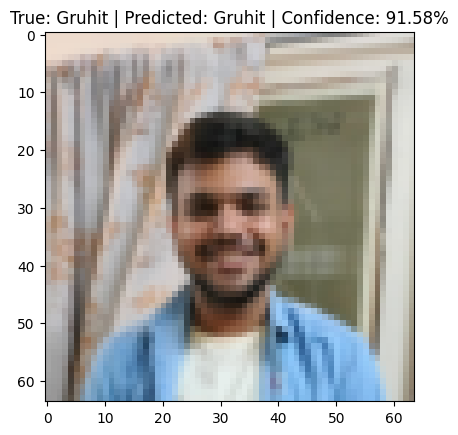

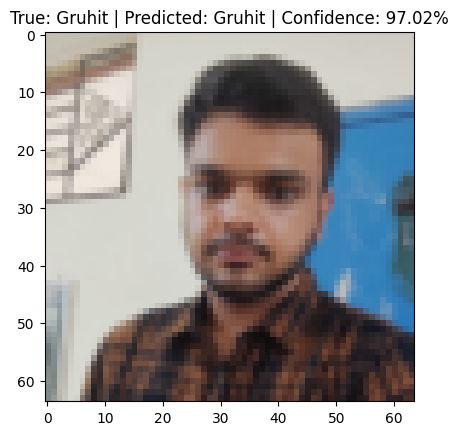

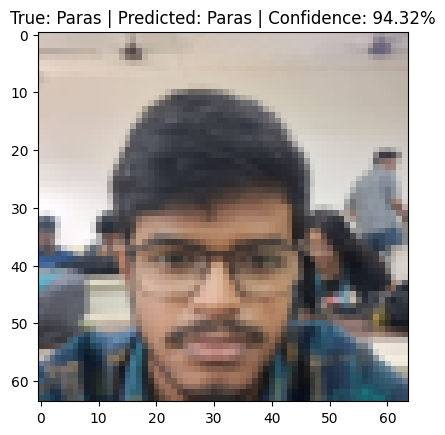

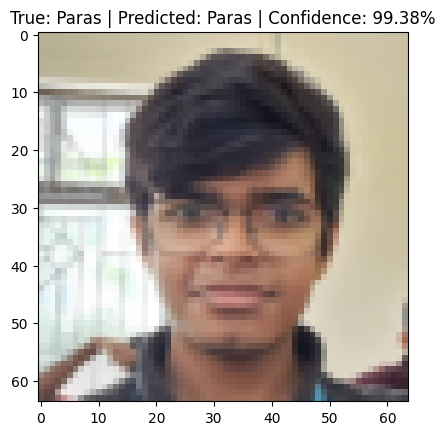


Overall Accuracy: 100.00%


In [33]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title:
        ax.set_title(title)
    plt.pause(0.001)
    return ax

def predict_person_and_display(model, test_loader, class_names):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted_idx = torch.max(probabilities, 1)
            predicted_name = class_names[predicted_idx.item()]
            correct += (predicted_idx == labels).sum().item()
            total += len(labels)
            true_name = class_names[labels.item()]
            accuracy = confidence.item() * 100
            image_tensor = inputs.squeeze(0)
            imshow(image_tensor, title=f"True: {true_name} | Predicted: {predicted_name} | Confidence: {accuracy:.2f}%")
    overall_accuracy = 100 * correct / total
    print(f"\nOverall Accuracy: {overall_accuracy:.2f}%")

predict_person_and_display(model, test_loader, class_names)